In [ ]:
%pip install pywt numpy matplitlib pathlib xarray

### Utility functions

Run the cell below, but feel free to ignore this code — it’s some utility functions we’ll use later for convenience.

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def calc_wavelet_spectrum(sig, sampling_frequency, number_of_freqs, bandwidth, center_frequency):
    '''
    Calculates the time-resolved power spectrum of a signal using Morlet wavelets

    Args:
        sig: signal that the wavelet spectrum is calculated for
        sampling_frequency: sampling frequency of signal
        number_of_freqs: number of frequencies the wavelet spectrum is calculated for
        bandwidht: the bandwidth of the Morlet wavelet
        center_frequency: the central frequency of the Morlet wavelet
    Returns:
        freqs: frequencies for which the the spectral values are calculated for
        spectrum_amp: spectral amplitudes
    '''
    # the bandwidth and the central frequency sets which Morlet wavelet is used
    wavelet = "cmor"+str(bandwidth)+"-"+str(center_frequency)

    # widths of the Morlet wavelet determines which frequencies the wavelet spectrum is calculated for
    widths = np.logspace(start=3, stop=10, num=number_of_freqs, base=2)

    sampling_period = 1/sampling_frequency
    spectrum, freqs = pywt.cwt(sig, widths, wavelet, sampling_period=sampling_period)

    # take absolute value to get real part and therefore amplitude of spectrum
    spectrum_amp = np.abs(spectrum)

    return freqs, spectrum_amp

def plot_spectrum_with_coi(time, freqs, spectrum, t_coi, apply_shading=True) -> None:
    '''
    Plots wavelet spectrum together with cone-of-influence

    Args:
        time: time points of spectrum
        freqs: frequencies the spectrum is calculated for
        spectrum: wavelet spectrum
        t_coi: time-points of cone-of-influence
        apply_shading: whether to apply shading to spectrum plot
    '''

    # plot wavelet spectrum
    if apply_shading:
        plt.pcolormesh(time, freqs, spectrum, cmap='plasma', shading='gouraud')
    else:
        plt.pcolormesh(time, freqs, spectrum, cmap='plasma')
    plt.ylim([0,100])

    # plot cone of influence
    plt.plot(time[0]+t_coi, np.arange(freqs.size)[::-1], 'g-', label = 'Cone of influence')
    plt.plot(time[-1]-t_coi, np.arange(freqs.size)[::-1],'g-')

    plt.xlabel('Time from stimulus onset (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Time-resolved frequency spectrum with\ncone of influence')
    plt.legend();

class utils:
    calc_wavelet_spectrum = calc_wavelet_spectrum
    plot_spectrum_with_coi = plot_spectrum_with_coi

## Download dataset

In [2]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')
else:
    print('Dataset already downloaded')

Dataset already downloaded


In [3]:
from pathlib import Path
import xarray as xr

#### Load LFP data

In [4]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

# Introduction

Sometimes, it's not enough to know *that* an oscillation at a specific frequency is present in your signal, you also need to know *when* the oscillation occurred. For that, we have to do a time-resolved frequency analysis of the signal. That means that you compute a power spectrum that shows how the power of different frequencies in your signal vary over time. In this notebook, you will learn about methods for computing time-resolved frequency spectra of signals.

## Section 1

### Time-resolved frequency analysis with Morlet wavelets

One of the most important and frequently used methods for computing time-resolved frequency spectra is to convolve the signal with Morlet wavelets. Morlet wavelets are wavelets with specific frequencies, and the process of convolving them with the signal can be seen as a matching process. You check how well the frequency of the signal matches with the frequency of the Morlet wavelet at a given time point. The better the match is, the higher the power of the spectrum will be for that frequency at that time point. The plot below illustrates a Morlet wavelet whose frequency matches the frequency of the signal.

<br>
<img src="Resources/morlet_wavelet_matching_signal_illustration.png" width="35%" height="15%">

| Code | Description |
| :-- | :-- |
| `freqs, spectrum_amp = utils.calc_wavelet_spectrum(sig, sampling_frequency)` | Calculates the wavelet spectrum `spectrum` for a signal `sig` with a given `sampling_frequency`. `number_of_freqs` sets the number of frequencies the spectrum is calculated for. `bandwidth` and `center_frequency` sets the parameters for the Morlet wavelet. |
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` defines the colormap and the interpolation applied to the plot, respectively. |

In [5]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

**Example**: Calculate the time-resolved power spectrum for the constructed signal below using a Morlet wavelet. Plot the resulting spectrum using the `pcolormesh` function.

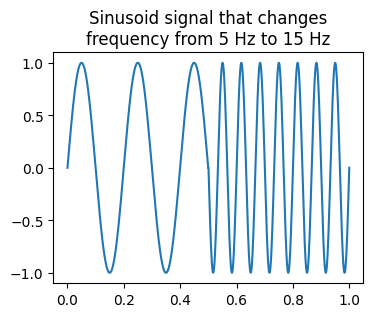

In [6]:
# provided

# Generate signal
sampling_frequency = 1000
durationA = 0.5
time_vecA = np.linspace(0,durationA,int(sampling_frequency*durationA)) # seconds
frequencyA = 5 # Hz
sineA = np.sin(2*np.pi*frequencyA*time_vecA)

durationB = 0.5
time_vecB = np.linspace(durationA, durationA+durationB, int(sampling_frequency*durationB)) # seconds
frequencyB = 15 # Hz
sineB = np.sin(2*np.pi*frequencyB*time_vecB)

time_vec = np.linspace(0,durationA+durationB,int(sampling_frequency*(durationA+durationB)))
sig = np.concatenate([sineA,sineB])

plt.figure(figsize=(4,3))
plt.plot(time_vec,sig)
plt.title(f'Sinusoid signal that changes\nfrequency from {frequencyA} Hz to {frequencyB} Hz');

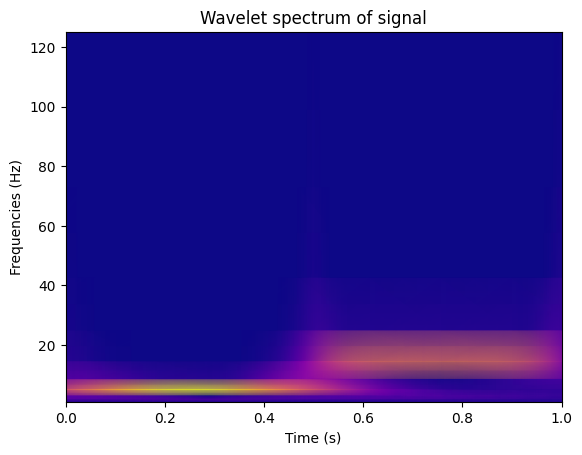

In [7]:
# solution

number_of_freqs = 10
bandwidth = 1.5
center_frequency = 1.0
freqs, spectrum = utils.calc_wavelet_spectrum(sig, sampling_frequency, number_of_freqs, bandwidth, center_frequency)

plt.pcolormesh(time_vec, freqs, spectrum, cmap = 'plasma', shading='gouraud')
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title('Wavelet spectrum of signal');

**Exercise**: Calculate the time-resolved power spectrum for the same constructed sinusoid below using a Morlet wavelet. But this time change the `number_of_freqs` to ``100``. This parameter specifices how many frequencies to calculate the spectrum for. Plot the result using the `pcolormesh` function. 

What happens to the frequency resolution?

In [8]:
# solution


The Morlet wavelet comes in many different shapes and sizes. There are two parameters that determine which kind of Morlet wavelet is used in the calculation of the spectrum: the ``bandwidth`` and the ``center frequency`` of the wavelet. The ``bandwidth`` determines how **broad** the wavelet is and the ``center frequency`` determines **how many oscillations** it has. Wavelets with different bandwidths and center frequencies are illustrated in the figure below.

<br>
<img src="Resources/different_morlet_wavelet_illustrations.png" width="50%" height="40%">

**Exercise**: Calculate the time-resolved power spectrum for the same constructed sinusoid below using a Morlet wavelet. Keep the `number_of_frequencies` parameter at 100, but change the ``center_frequency`` parameter to 0.5.

What happens to the frequency resolution now?

In [9]:
# solution


**Exercise**: Change the ``center_frequency`` parameter to 2.0. Calculate and plot the time-resolved spectrum for the same constructed sinusoid below using a Morlet wavelet.

What happens to the frequency resolution? What happens to the time resolution?

In [10]:
# solution


**Exercise**: Set the ``center_frequency`` parameter back to ``1.0``, but change the ``bandwidth`` parameter to ``0.5``. Calculate and plot the time-resolved spectrum for the same constructed sinusoid again.

What happens to the frequency resolution this time?

In [11]:
# solution



**Exercise**: Change the ``bandwidth`` of the wavelet to ``2.5``. Calculate and plot the spectrum using `pcolormesh`. 

What happens to the frequency resolution compared to the last plot?

In [12]:
# solution



**Comment**: The exercises and plots above should demonstrate that if you increase the time resolution, you decrease the frequency resolution in your spectrum. And vice versa, if you increase the frequency resolution, you decrease the time resolution of your spectrum. There's a fundamental trade-off between resolution in frequency and resolution in time.

The different parameters used for the Morlet wavelet determines where you strike the balance between frequency and time resolution. The frequency resolution increases and the time resolution goes down with greater bandwidth or greater center frequency.

## Section 2

### Time-resolved frequency analysis with morlet wavelets on spikes and LFP data

In this section, you will use Morlet wavelets to calculate the time-resolved spectra for spikes and LFP data.

| Code | Description |
| :-- | :-- |
| `freqs, spectrum_amp = utils.calc_wavelet_spectrum(sig, sampling_frequency)` | Calculates the wavelet spectrum `spectrum` for a signal `sig` with a given `sampling_frequency`. `number_of_freqs` sets the number of frequencies the spectrum is calculated for. `bandwidth` and `center_frequency` sets the parameters for the Morlet wavelet. |
| `np.mean(data, axis = (dim_num))` or `data.mean(axis = dim_num)` | Calculate the average of the data across the `dim_num` dimension of the array. |
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` defines the colormap and the interpolation applied to the plot, respectively. |

#### Extract LFP data

In [13]:
lfp_trials = dataset['lfp_trials']
lfp_whole_rec = dataset['lfp_whole_recording']
channels_depth = dataset['channel_depth']

sampling_frequency_lfp = dataset.sampling_frequency_lfp # Hz
time_lfp = lfp_trials.time_from_stimulus_onset_lfp.values # ms

We will stick to the parameters for the Morlet wavelet used in the first example in this section. That is, `bandwidth = 1.5`, and `center_frequency = 1.0`.

**Example**: Calculate the time-resolved power spectrum of an LFP trace from the channel on index 8 in trial 0 using a morlet wavelet. Plot the result using `pcolormesh`.

In [14]:
ichan = 8
itrial = 0

number_of_freqs = 100
bandwidth = 1.5
center_frequency = 1.0
freqs, spectrum = utils.calc_wavelet_spectrum(lfp_trials[ichan, itrial], sampling_frequency_lfp, number_of_freqs, bandwidth, center_frequency)

Text(0.5, 1.0, 'Power spectrum')

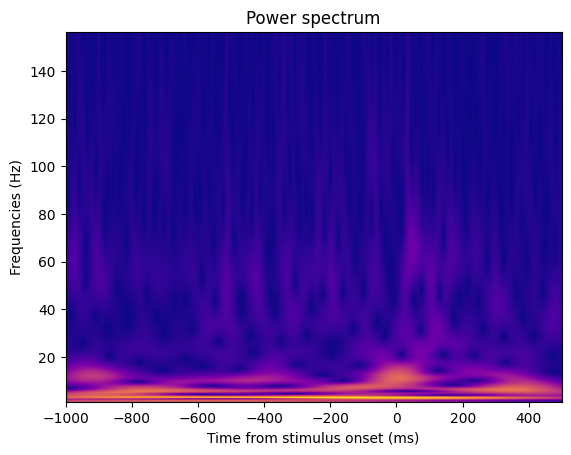

In [15]:
# plot result using matplotlib's pcolormesh
plt.pcolormesh(time_lfp, freqs, spectrum, cmap = 'plasma', shading='gouraud')
plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel('Frequencies (Hz)')
plt.title('Power spectrum')

**Exercise**: Calculate the time-resolved power spectrum of an LFP trace from the channel on index ``2`` in trial ``0`` using a Morlet wavelet. Plot the result using `pcolormesh`. 

Is there a noticable increase in power for some frequencies at any time during the trial?

In [16]:
# solution

**Exercise**: Calculate the spectrum of an LFP from the channel on index 8 in *all trials* (you don't need to use a for loop). Calculate the trial-averaged spectrum and plot the result.

*Tip*: You might want to decrease the `number_of_freqs` parameter if you feel that it takes too long to calculate the spectrum.

In [17]:
# solution


#### Extract spike data

Run cell below to extract spike data

In [18]:
spike_counts_LGN = dataset['spike_counts_LGN']
spike_counts_V1 = dataset['spike_counts_V1']
spike_counts_LM = dataset['spike_counts_LM']

time_spikes = spike_counts_LM.time_from_stimulus_onset_spikes
sampling_frequency_spikes = dataset.sampling_frequency_spikes

**Exercise**: Calculate the time-resolved power spectrum for the spikes of the LM cell at index 6. Calculate the trial averaged spectrum and plot the result using `pcolormesh`.

Is there a notable increase in power at any point during the trial?

NB: You have to change the sampling frequency parameter from `sampling_frequency_lfp` to `sampling_frequency_spikes` in the `calc_wavelet_spectrum` function. And the time in the `pcolormesh` function also needs to be changed to `time_spikes`.

In [19]:
# solution


**Exercise**: Calculate the time-resolved power spectrum for the spikes of the LGN cell at index 0 using a morlet wavelet. Calculate the trial averaged spectrum and plot the result using `pcolormesh`.

Does this cell have a marked increase in power at any point?

In [20]:
# solution



## Section 3

### Cone of influence

When the signal is convolved with a wavelet, the wavelet will partly be outside of the signal window close to the edges (the start and end point of your signal). This will lead to inaccurate spectral estimates in these regions. Which parts of your spectral estimate that may be influenced by such edge-effect artifacts can be calculated  with the formula for a "cone of influence". Regions of your spectrum outside this cone can't be trusted and should be ignored when examining your time-resolved power spectrum. The formula for the cone of influence is given as:

$$t_{COI} = \frac{\sigma}{2\pi}\frac{\sqrt{2}}{f}$$

where $\sigma$ is the bandwidth of the Morlet wavelet and $f$ is frequencies for which the spectrum is calculated.

| Code | Description |
| :-- | :-- |
| `freqs, spectrum_amp = utils.calc_wavelet_spectrum(sig, sampling_frequency)` | Utility function to calculate the wavelet spectrum `spectrum` for a signal `sig` with a given `sampling_frequency`. `number_of_freqs` sets the number of frequencies the spectrum is calculated for. `bandwidth` and `center_frequency` sets the parameters for the Morlet wavelet. |
| `t_coi = (bandwidth) / (2*np.pi) * np.sqrt(2) / freqs` | Calculate the cone of influence (COI) for a spectrum computed with a Morlet wavelet with a given bandwidth. |
| `utils.plot_spectrum_with_coi(time_lfp, freqs, spectrum, t_coi, apply_shading = True)` | Makes a plot of the wavelet spectrum with the cone of influence superimposed.

**Example**: Calculate the cone of influence (COI) for the Morlet wavelet spectrum computed for a single channel, single trial LFP trace (``ichan = 2``, ``itrial = 10``). Plot the COI on top of the the wavelet spectrum. You can use the utility functions to calculate the spectrum and to make the plot.

In [21]:
ichan = 2
itrial = 10

number_of_freqs = 50
bandwidth = 1.5
center_frequency = 1.0
freqs, spectrum = utils.calc_wavelet_spectrum(lfp_trials[ichan, itrial], sampling_frequency_lfp, number_of_freqs, bandwidth, center_frequency)

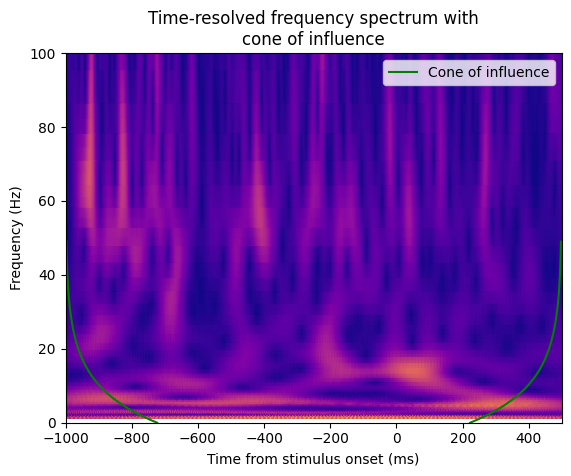

In [22]:
# solution 

t_coi = (bandwidth) / (2*np.pi) * np.sqrt(2) / freqs * 1E3

# plot spectrum and cone of influence
utils.plot_spectrum_with_coi(time_lfp, freqs, spectrum, t_coi)

**Exercise**: Change the ``bandwidth`` parameter to ``3.5`` and calculate of the spectrum for the same LFP trace. Calculate and plot the COI on top of the spectrum below. What happens to the COI?

In [23]:
# solution

In [24]:
# solution 


One way to avoid having to disregard a significant part of the spectrum because it's outside of the COI is to calculate it for a larger time window. 

**Exercise**: Below, the spectrum is calculated with `bandwidth=3.5` for an LFP trace for a *quarter* of the whole recording period instead of just a single trial. Calculate and plot the COI for this spectrum. What happens to the COI in this case? Is it a large part of the spectrum that you have to disregard because it's outside of the COI? 

*Hint*: It's probably best to set the `apply_shading` parameter to `False` in the `plot_spectrum_with_coi` function to make the plotting go faster.

In [ ]:
ichan = 2
lfp_trace = lfp_whole_rec[ichan, :int(lfp_whole_rec.shape[1]/4)]
time_lfp_part_of_rec = lfp_whole_rec.time_whole_rec.values[:len(lfp_trace)]

number_of_freqs = 10
bandwidth = 3.5
center_frequency = 1.0
freqs, spectrum = utils.calc_wavelet_spectrum(lfp_trace, sampling_frequency_lfp, number_of_freqs, bandwidth, center_frequency)

In [34]:
# solution 


## Section 4

### Reorganizing spectrum calculated for whole period into trials.

If you want to look at the spectrum in individual trials or the trial average, but you have calculated the spectrum for a whole recording period to limit the influence of edge effects, you have to reorganize the calculated spectrum into trials again. To do that, you can use information about the time points at which the stimuli are presented and logical indexing.

| Code | Description |
| :-- | :-- |
| `mask = np.logical_and(array > start, array < stop)` | Create logical mask where both conditions are met. The array, e.g. a time vector, is bigger than the starting point and smaller than the stopping point. |

Run cell below to load meta data on stimulus presentation start times and LFP from whole stimulus presentation period

In [25]:
stim_start_times = dataset['stimulus_start_times'].values

ichan = 2
lfp_trace = lfp_whole_rec[ichan]
time_lfp_whole_rec = lfp_whole_rec.time_whole_rec.values

**Example**: Get LFP from 100 ms before the first stimulus presentation to 250 ms after onset using logical indexing. Plot the LFP in this selected window.

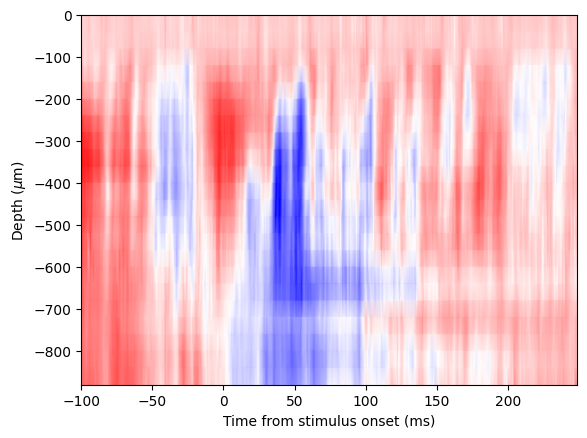

In [26]:
time_before_onset = 100
time_after_onset = 250

# get time of first stimulus presentation
idx_stim_start = 0
time_stim_onset = stim_start_times[idx_stim_start]

# create boolean mask for time window around stimulus onset
mask_stim_window = np.logical_and(time_lfp_whole_rec > (time_stim_onset-time_before_onset), 
                                  time_lfp_whole_rec < (time_stim_onset+time_after_onset))

# get time points in window
time_lfp_window = time_lfp_whole_rec[mask_stim_window]
time_lfp_window -= (time_lfp_window.min()+time_before_onset)

# get lfp in time window
lfp_window = lfp_whole_rec[:, mask_stim_window]

# plot lfp in selected time window
plt.pcolormesh(time_lfp_window, channels_depth, lfp_window, cmap='bwr', shading='gouraud')
plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel(r'Depth ($\mu$m)');

**Exercise**: Get LFP from 500 ms before the first stimulus presentation to 500 ms after onset of the 5th stimulus presentation using logical indexing. Plot the LFP in this selected window.

In [27]:
# solution

**Example**: Reorganize the array containing LFP from the whole recording into an array organized by trials with 250 ms before and after stimulus onset by using the stimulus start time information. 

*Hint*: Loop through all trials, get the lfp 250 ms before and after stimulus onset in each trial, and store it in a variable that contains the LFP in this window for all stimulus presentations. Plot the trial averaged LFP in this window.

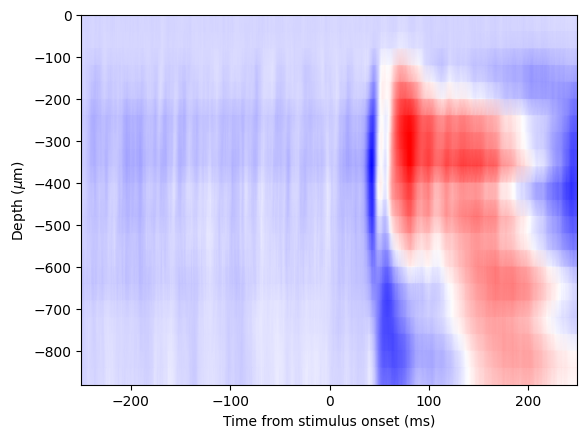

In [28]:
time_before_onset = 250
time_after_onset = 250

n_trials = lfp_trials.shape[1]
lfp_windows = []
for idx_stim_start in range(n_trials-1): # 1 is subtracted just because the data was cut too early in the last trial
    # get time of selected stimulus presentation
    time_stim_onset = stim_start_times[idx_stim_start]

    # create boolean mask for time window around stimulus onset
    mask_stim_window = np.logical_and(time_lfp_whole_rec > time_stim_onset-time_before_onset, 
                                      time_lfp_whole_rec < time_stim_onset+time_after_onset)

    # get lfp in time window and store in list
    lfp_windows.append(lfp_whole_rec[:, mask_stim_window])

# get time points in window
time_lfp_window = time_lfp_whole_rec[mask_stim_window]
time_lfp_window -= (time_lfp_window.min()+time_before_onset)

# calculate trial averaged lfp
lfp_window_trial_avg = np.mean(lfp_windows, axis = 0)

plt.pcolormesh(time_lfp_window, channels_depth, lfp_window_trial_avg, cmap='bwr', shading='gouraud')
plt.xlabel('Time from stimulus onset (ms)')
plt.ylabel(r'Depth ($\mu$m)');

**Exercise**: Reorganize the spectrum calculated for the whole recording below into trials by using the stimulus start time information. Recipe: Loop through all trials, get the lfp 250 ms before and after stimulus onset in each trial, and store it in a variable that contains the spectrum in this window for all stimulus presentations. Plot the trial averaged spectrum in this window.

*Note*: Calculating the spectrum for the whole recording period will take some time.

In [29]:
# provided
number_of_freqs = 10
bandwidth = 3.5
center_frequency = 1.0
freqs, spectrum = utils.calc_wavelet_spectrum(lfp_trace, sampling_frequency_lfp, number_of_freqs, bandwidth, center_frequency)

In [ ]:
# solution


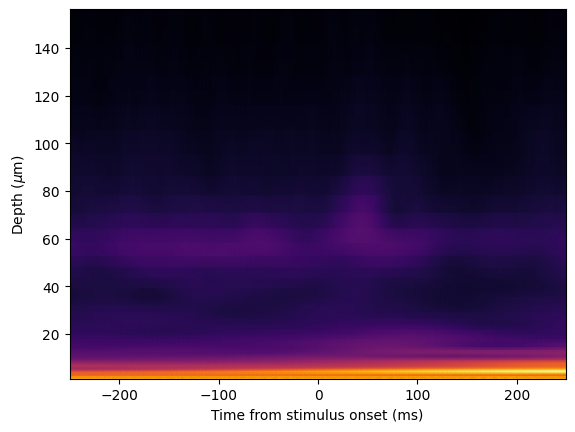